# 4-Parametric Sensitivity

In [1]:
using DifferentialEquations
using PyPlot
using Statistics
using FileIO
using FFTW
include("GalerkinFuncs.jl");
# Base model parameters
N  = 10
c1 = 0.1
c2 = 0.06
Kb  = 0.72
xfb = 0.25
τb  = 0.2
Ma = 0.005
γ  = 1.4

1.4

## Changing τ

In [2]:
@time begin
τs = range(0.2,stop=0.29,length=4)
S = zeros(12,100)
for (i,τv) in enumerate(τs)
    global params = setParams(N,c1,c2,Kb,xfb,τv,false)
    # Solve the direct equation
    u0 = load("data/init.jld", "u0");
    h(p,t) = u0
    params.tMax  = 400
    tspan = (-400,params.tMax+3)
    lags = [τv]
    prob = DDEProblem(RHS,u0,h,tspan,params,constant_lags=lags,reltol=1e-12)
    alg = MethodOfSteps(Vern6())
    solDir = solve(prob,alg);
    # Add the direct solution to the parameters for the adjoint equation
    params.solDir = solDir;
    
    # Find the period
    tRange = range(0,stop=400,length=400*100)
    testSeries = zeros(length(tRange))
    for (i,t) in enumerate(tRange)
        testSeries[i]=solDir(t)[1]
    end
    testSeriesFFT = fft(testSeries)
    # Remove the mean
    testSeriesFFT[1] = 0
    dt = tRange[2]-tRange[1]
    Sfreq = 1/dt
    freqs = range(0,Sfreq,length=400*100)
    idx = argmax(abs.(testSeriesFFT[1:200*100]))
    T = 1/freqs[idx]
    params.T = T
    # Add the direct solution to the parameters for the adjoint equation
    params.solDir = solDir;
    
    # Run the adjoint from tMax back to zero
    tspan = (0,params.tMax)
    u0 = load("data/initAdj.jld","u0")
    h(p,t) = u0
    prob = DDEProblem(RHSadj,u0,h,tspan,params,constant_lags=lags,reltol=1e-12)
    alg = MethodOfSteps(Vern6())
    solAdj = solve(prob,alg)
    params.solAdj = solAdj;
        
    # Calculate the Bilinear form to find the normalisation
    ωn = 2π/params.T
    NT = 200
    tRange = range(0,stop=params.T,length=NT)
    norm = zeros(NT)
    int = zeros(NT)
    inner = zeros(NT)
    for (k,t) in enumerate(tRange)
        norm[k],inner[k],int[k] = bilinearForm(2*params.T+t,params)
    end
    normV = mean(norm)
    params.phaseSensNorm = ωn/normV
    xRange = range(0,stop=1,length=100) 
    
    # Find the synchronisability as the pressure location is varied
    
    for (j,xLoc) in enumerate(xRange)
        fn = zeros(2*params.N)
        for i in 1:params.N
            fn[params.N+i] = 2π*i*sin(i*π*xLoc)
        end    
        tRange = range(0,stop=params.T,length=NT) 
        Γ = zeros(NT)
        g(t) = cos(t)*fn*params.phaseSensNorm
        for (l,t) in enumerate(tRange)
            Γ[l] = phaseCouplingFunction(t,1,g,params)
        end
        S[i,j] = maximum(Γ)-minimum(Γ)
    end
end
end

274.519725 seconds (5.03 G allocations: 245.030 GiB, 10.44% gc time)


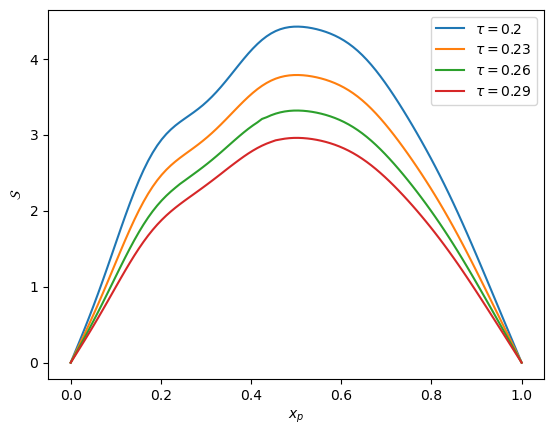

PyObject Text(0.5, 26.300000000000004, '$x_p$')

In [3]:
xRange = range(0,stop=1,length=100) 
for i in 1:4
    plot(xRange,S[i,:])
end
legend([L"\tau=0.2",L"\tau=0.23",L"\tau=0.26",L"\tau=0.29"])

ylabel(L"\mathcal{S}")
xlabel(L"x_p")

## Changing xf

In [4]:
@time begin

xfs = range(0.25,stop=0.33,length=5)
S = zeros(12,100)
for (i,xfv) in enumerate(xfs)
    global params = setParams(N,c1,c2,Kb,xfv,τb,false)
    # Solve the direct equation
    u0 = load("data/init.jld", "u0");
    h(p,t) = u0
    params.tMax  = 400
    tspan = (-1200,params.tMax+3)
    lags = [τb]
    prob = DDEProblem(RHS,u0,h,tspan,params,constant_lags=lags,reltol=1e-12)
    alg = MethodOfSteps(Vern6())
    solDir = solve(prob,alg);
    # Add the direct solution to the parameters for the adjoint equation
    params.solDir = solDir;
    
    # Find the period
    tRange = range(0,stop=400,length=400*100)
    testSeries = zeros(length(tRange))
    for (i,t) in enumerate(tRange)
        testSeries[i]=solDir(t)[1]
    end
    testSeriesFFT = fft(testSeries)
    # Remove the mean
    testSeriesFFT[1] = 0
    dt = tRange[2]-tRange[1]
    Sfreq = 1/dt
    freqs = range(0,Sfreq,length=400*100)
    idx = argmax(abs.(testSeriesFFT[1:200*100]))
    T = 1/freqs[idx]
    params.T = T
    # Add the direct solution to the parameters for the adjoint equation
    params.solDir = solDir;
    
    # Run the adjoint from tMax back to zero
    tspan = (0,params.tMax)
    u0 = load("data/initAdj.jld","u0")
    h(p,t) = u0
    prob = DDEProblem(RHSadj,u0,h,tspan,params,constant_lags=lags,reltol=1e-12)
    alg = MethodOfSteps(Vern6())
    solAdj = solve(prob,alg)
    params.solAdj = solAdj;
        
    # Calculate the Bilinear form to find the normalisation
    ωn = 2π/params.T
    NT = 200
    tRange = range(0,stop=params.T,length=NT)
    norm = zeros(NT)
    int = zeros(NT)
    inner = zeros(NT)
    for (k,t) in enumerate(tRange)
        norm[k],inner[k],int[k] = bilinearForm(2*params.T+t,params)
    end
    normV = mean(norm)
    params.phaseSensNorm = ωn/normV
    xRange = range(0,stop=1,length=100) 
    
    # Find the synchronisability as the pressure location is varied
    
    for (j,xLoc) in enumerate(xRange)
        fn = zeros(2*params.N)
        for i in 1:params.N
            fn[params.N+i] = 2π*i*sin(i*π*xLoc)
        end    
        tRange = range(0,stop=params.T,length=NT) 
        Γ = zeros(NT)
        g(t) = cos(t)*fn*params.phaseSensNorm
        for (l,t) in enumerate(tRange)
            Γ[l] = phaseCouplingFunction(t,1,g,params)
        end
        S[i,j] = maximum(Γ)-minimum(Γ)
    end
end
end

371.043584 seconds (7.05 G allocations: 346.193 GiB, 11.41% gc time)


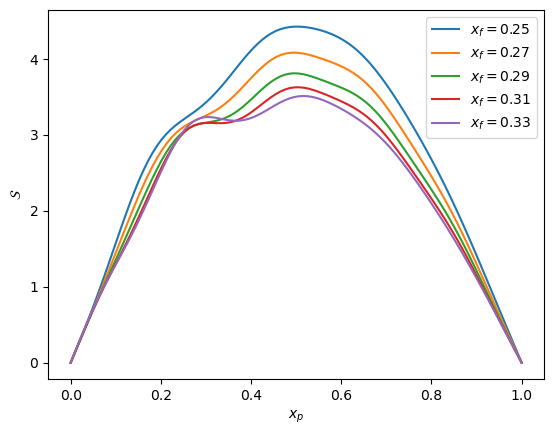

PyObject Text(0.5, 26.300000000000004, '$x_p$')

In [5]:
for i in 1:5
    plot(xRange,S[i,:])
end
legend([L"x_f=0.25",L"x_f=0.27",L"x_f=0.29",L"x_f=0.31",L"x_f=0.33"])

ylabel(L"\mathcal{S}")
xlabel(L"x_p")

## Changing K

In [6]:
@time begin

Ks = range(0.72,stop=0.99,length=4)
S = zeros(12,100)
for (i,Kv) in enumerate(Ks)
    global params = setParams(N,c1,c2,Kv,xfb,τb,false)
    # Solve the direct equation
    u0 = load("data/init.jld", "u0");
    h(p,t) = u0
    params.tMax  = 400
    tspan = (-400,params.tMax+3)
    lags = [τb]
    prob = DDEProblem(RHS,u0,h,tspan,params,constant_lags=lags,reltol=1e-12)
    alg = MethodOfSteps(Vern6())
    solDir = solve(prob,alg);
    # Add the direct solution to the parameters for the adjoint equation
    params.solDir = solDir;
    
    # Find the period
    tRange = range(0,stop=400,length=400*100)
    testSeries = zeros(length(tRange))
    for (i,t) in enumerate(tRange)
        testSeries[i]=solDir(t)[1]
    end
    testSeriesFFT = fft(testSeries)
    # Remove the mean
    testSeriesFFT[1] = 0
    dt = tRange[2]-tRange[1]
    Sfreq = 1/dt
    freqs = range(0,Sfreq,length=400*100)
    idx = argmax(abs.(testSeriesFFT[1:200*100]))
    T = 1/freqs[idx]
    params.T = T
    # Add the direct solution to the parameters for the adjoint equation
    params.solDir = solDir;
    
    # Run the adjoint from tMax back to zero
    tspan = (0,params.tMax)
    u0 = load("data/initAdj.jld","u0")
    h(p,t) = u0
    prob = DDEProblem(RHSadj,u0,h,tspan,params,constant_lags=lags,reltol=1e-12)
    alg = MethodOfSteps(Vern6())
    solAdj = solve(prob,alg)
    params.solAdj = solAdj;
        
    # Calculate the Bilinear form to find the normalisation
    ωn = 2π/params.T
    NT = 200
    tRange = range(0,stop=params.T,length=NT)
    norm = zeros(NT)
    int = zeros(NT)
    inner = zeros(NT)
    for (k,t) in enumerate(tRange)
        norm[k],inner[k],int[k] = bilinearForm(2*params.T+t,params)
    end
    normV = mean(norm)
    params.phaseSensNorm = ωn/normV
    xRange = range(0,stop=1,length=100) 
    
    # Find the synchronisability as the pressure location is varied
    
    for (j,xLoc) in enumerate(xRange)
        fn = zeros(2*params.N)
        for i in 1:params.N
            fn[params.N+i] = 2π*i*sin(i*π*xLoc)
        end    
        tRange = range(0,stop=params.T,length=NT) 
        Γ = zeros(NT)
        g(t) = cos(t)*fn*params.phaseSensNorm
        for (l,t) in enumerate(tRange)
            Γ[l] = phaseCouplingFunction(t,1,g,params)
        end
        S[i,j] = maximum(Γ)-minimum(Γ)
    end
end
end

281.536346 seconds (5.49 G allocations: 259.564 GiB, 10.67% gc time)


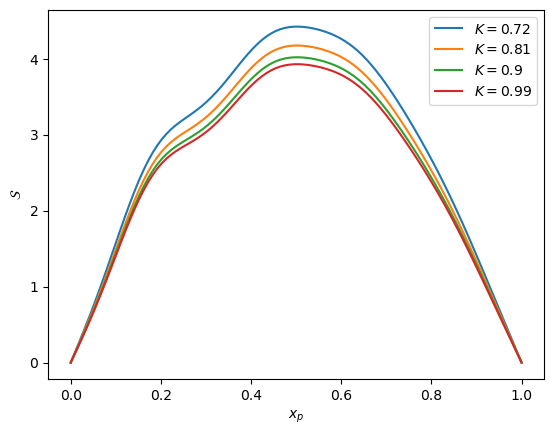

PyObject Text(0.5, 26.300000000000004, '$x_p$')

In [7]:
for i in 1:4
    plot(xRange,S[i,:])
end
legend([L"K=0.72",L"K=0.81",L"K=0.9",L"K=0.99"])

ylabel(L"\mathcal{S}")
xlabel(L"x_p")